In [1]:
import numpy as np
import pandas as pd 
import os
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset,DataLoader
import torchvision 
from torchvision import transforms, models
from tqdm.notebook import tqdm
from PIL import Image
import seaborn as sns
from collections import OrderedDict


In [2]:
from glob import glob
import torch.nn.functional as F
from torch import nn, optim

In [3]:
data_dir = {
    "train" : "/media/brats/DRIVE1/akansh/DeepXrays/Data/raw/Chest XR covid/train/",
    "valid": "/media/brats/DRIVE1/akansh/DeepXrays/Data/raw/Chest XR covid/validation/",
    "test" : "/media/brats/DRIVE1/akansh/DeepXrays/Data/raw/Chest XR covid/test/"
}

In [4]:
label_csv = {"train": '/media/brats/DRIVE1/akansh/DeepXrays/Data/processed/train_labels.csv',
            "valid": "/media/brats/DRIVE1/akansh/DeepXrays/Data/processed/validation_labels.csv",
            "test": "/media/brats/DRIVE1/akansh/DeepXrays/Data/raw/submission.csv"}

In [6]:
train = pd.read_csv(label_csv['train'])
valid = pd.read_csv(label_csv['valid'])
test = pd.read_csv(label_csv['test'])

In [53]:
filenames = []
for root, dirs, files in os.walk(data_dir['valid']):
    for file in files:
        if file.endswith('.jpg') or file.endswith('.png') :
            filenames.append(file)
    

In [54]:
len(filenames)

3432

In [55]:
### Dataloader
class covid_dataset(Dataset):
    def __init__(self, image_loc, label_loc, transform, data_type = 'train'):
        filenames = []
        for root, dirs, files in os.walk(image_loc):
            for file in files:
                if file.endswith('.jpg') == True or file.endswith('.png') == True :
                    filenames.append(file)
#         print(len(filenames))
        if data_type == 'train' or data_type == 'valid':
            self.full_filenames = glob(image_loc+'*/*.*')
        else:
            self.full_filenames = glob(image_loc+'*.*')
#         print(len(self.full_filenames))
            
            
        label_df = pd.read_csv(label_loc)
        label_df.set_index("case", inplace = True)
        self.labels = [label_df.loc[filename].values[0] for filename in filenames]
        
        self.transform = transform
        
    def __len__(self):
        return len(self.full_filenames)
    
    def __getitem__(self,idx):
        image = Image.open(self.full_filenames[idx])
        image = image.convert('RGB')
        images = np.array(images)
        
        image = self.transform(image)
        return image, self.labels[idx]
        

In [56]:
data_transforms = {
    
    'train': transforms.Compose([
        transforms.Resize((256,256)),
        transforms.CenterCrop((224,224)),
        transforms.RandomVerticalFlip(p =.5),
        transforms.RandomHorizontalFlip(p = 0.5),
        transforms.ColorJitter((0.85,1.05)),
        transforms.RandomRotation((-30,30)),
        transforms.ToTensor(),
        transforms.Normalize([0.5027,0.5027,0.5027],[0.2466, 0.2466, 0.2466])
        
    ]),
    
    'valid' : transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.5027,0.5027,0.5027],[0.2466, 0.2466, 0.2466])
    ])
    
    
}

In [57]:
valid_data = covid_dataset(image_loc = data_dir['valid'],
                          label_loc = label_csv['valid'],
                          transform = data_transforms['valid'],
                          data_type = 'valid')

train_data = covid_dataset(image_loc = data_dir['train'],
                          label_loc = label_csv['train'],
                          transform = data_transforms['train'],
                          data_type = 'train')


In [58]:
trainloader = DataLoader(train_data,batch_size = 64,shuffle = True)
validloader = DataLoader(valid_data,batch_size = 32,shuffle = False)

In [13]:
from efficientnet_pytorch import EfficientNet

In [14]:
model = EfficientNet.from_pretrained('efficientnet-b3', num_classes=3)

Loaded pretrained weights for efficientnet-b3


In [15]:
for param in model.parameters():
    param.requires_grad = True

In [16]:
device = 'cuda'

In [17]:
model = model.cuda()

In [18]:
classes_name = {0: 'covid', 1: 'normal', 2: 'pneumonia'}

In [22]:
import pandas as pd
import seaborn as sns

def calc_confusion_matrix(model, loader, device, nb_classes):
    confusion_matrix = np.zeros((nb_classes, nb_classes))
    with torch.no_grad():
        for i, (inputs, classes) in tqdm(enumerate(loader)):
            inputs = inputs.to(device)
            classes = classes.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for t, p in zip(classes, preds.view(-1)):
                    confusion_matrix[t.long(), p.long()] += 1
    return confusion_matrix.astype(int)


def plot_confusion_matrix(confusion_matrix, validloader, path_save):
    plt.figure(figsize=(15,10))

    class_names = ['covid', 'normal', 'pneumonia']
    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names).astype(int)
    heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    try:
        plt.savefig(path_save)
    except:
        pass


### Exploaring Transforms

In [21]:
image_1_cov = Image.open("/media/brats/DRIVE1/akansh/DeepXrays/Data/processed/Chest_XR_covid_resized_360/train/normal/normal-000100.jpg")
image_2_cov = Image.open( '/media/brats/DRIVE1/akansh/DeepXrays/Data/processed/Chest_XR_covid_resized_360/train/covid/covid-0001128.jpg',)

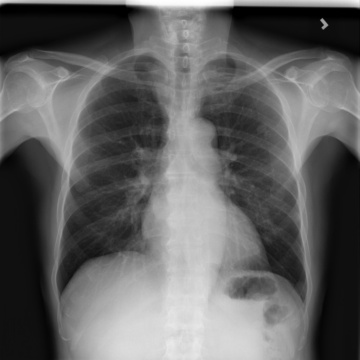

In [22]:
image_1_cov

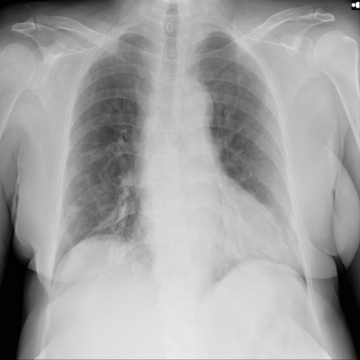

In [17]:
transforms.Resize((360,360))(image_2_cov)

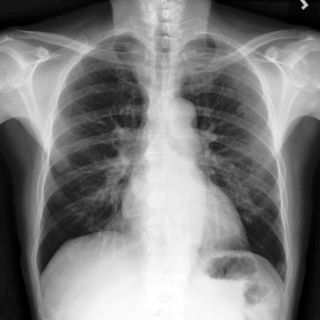

In [23]:
transforms.RandomEqualize(p=1)(transforms.CenterCrop((320,320))(transforms.Resize((360,360))(image_1_cov)))

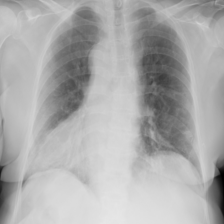

In [32]:
transforms.RandomHorizontalFlip(p = 1)(transforms.CenterCrop((224,224))(transforms.Resize((256,256))(image_2_cov)))

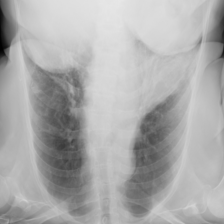

In [33]:
transforms.RandomVerticalFlip(p =.5)(transforms.CenterCrop((224,224))(transforms.Resize((256,256))(image_2_cov)))

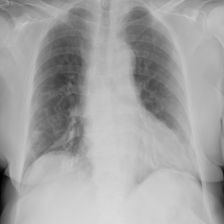

In [34]:
transforms.ColorJitter((0.85,1.05))(transforms.CenterCrop((224,224))(transforms.Resize((256,256))(image_2_cov)))

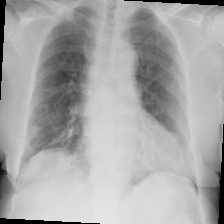

In [35]:
transforms.RandomRotation((30))(transforms.CenterCrop((224,224))(transforms.Resize((256,256))(image_2_cov)))

### Training

In [20]:
import torch.nn.functional as F

In [21]:
device = 'cuda'

In [22]:
critertion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr = 0.001)
schedular = optim.lr_scheduler.ReduceLROnPlateau(optimizer,factor = 0.1,patience = 5, verbose = True)
epochs = 20
valid_loss_min = np.Inf

In [23]:
def accuracy(y_pred,y_true):
    y_pred = F.softmax(y_pred, dim =1)
    top_p,top_class = y_pred.topk(1,dim = 1)
    equals = top_class == y_true.view(*top_class.shape)
    return torch.mean(equals.type(torch.FloatTensor))

In [25]:
valid_loss_min = np.inf
best_acc = 0.0

In [77]:
train_loss_hist = []
valid_loss_hist = []
train_acc_hist = []
valid_acc_hist = []


for i in range(epochs):
    
    train_loss = 0.0
    valid_loss = 0.0
    train_acc = 0.0
    valid_acc = 0.0 
    
    
    model.train()
    
    for images,labels in tqdm(trainloader):
        images = images.to(device)
        labels = labels.to(device)
        
        ps = model(images)
        loss = critertion(ps,labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_acc += accuracy(ps,labels)
        train_loss +=loss.item()
        
    avg_train_acc = train_acc / len(trainloader)
    train_acc_hist.append(avg_train_acc)
    avg_train_loss = train_loss / len(trainloader)
    train_loss_hist.append(avg_train_loss)
    
    model.eval()
    with torch.no_grad():
        for images,labels in tqdm(validloader):
            images = images.to(device)
            labels = labels.to(device)
            
            ps = model(images)
            loss = critertion(ps,labels)
            
            valid_acc += accuracy(ps,labels)
            valid_loss += loss.item()
            
        avg_valid_acc = valid_acc / len(validloader)
        valid_acc_hist.append(avg_valid_acc)
        avg_valid_loss = valid_loss / len(validloader)
        valid_loss_hist.append(avg_valid_loss)
        
        schedular.step(avg_valid_loss)
        
        if avg_valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).Saving model ...'.format(valid_loss_min,avg_valid_loss))
            torch.save({
                'epoch' : i,
                'model_state_dict' : model.state_dict(),
                'optimizer_state_dict' : optimizer.state_dict(),
                'valid_loss_min' : avg_valid_loss
            },'efficientNet-size.pt')
            
            valid_loss_min = avg_valid_loss
            
            
        if avg_valid_acc >= best_acc:
            print('Validation Accuracy increased ({:.6f} --> {:.6f}).Saving model ...'.format(best_acc,avg_valid_acc))
            torch.save({
                'epoch' : i,
                'model_state_dict' : model.state_dict(),
                'optimizer_state_dict' : optimizer.state_dict(),
                'valid_acc_max' : avg_valid_acc
            },'efficientNet_best_acc-size.pt')
            
            best_acc = avg_valid_acc
            
            
        
            
    print("Epoch : {} Train Loss : {:.6f} Train Acc : {:.6f}".format(i+1,avg_train_loss,avg_train_acc))
    print("Epoch : {} Valid Loss : {:.6f} Valid Acc : {:.6f}".format(i+1,avg_valid_loss,avg_valid_acc))
    
            
            
        

            


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Validation Accuracy increased (0.152625 --> 0.193866).Saving model ...
Epoch : 1 Train Loss : 0.027368 Train Acc : 0.989936
Epoch : 1 Valid Loss : 0.193866 Valid Acc : 0.950521


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 2 Train Loss : 0.026550 Train Acc : 0.990158
Epoch : 2 Valid Loss : 0.184781 Valid Acc : 0.947049


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 3 Train Loss : 0.027438 Train Acc : 0.989936
Epoch : 3 Valid Loss : 0.199865 Valid Acc : 0.948206


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 4 Train Loss : 0.025675 Train Acc : 0.990936
Epoch : 4 Valid Loss : 0.197417 Valid Acc : 0.948206


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 5 Train Loss : 0.027213 Train Acc : 0.990787
Epoch : 5 Valid Loss : 0.202354 Valid Acc : 0.949942


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 6 Train Loss : 0.027131 Train Acc : 0.989713
Epoch : 6 Valid Loss : 0.200412 Valid Acc : 0.945312


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 7 Train Loss : 0.029430 Train Acc : 0.988712
Epoch : 7 Valid Loss : 0.189346 Valid Acc : 0.949653


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch     8: reducing learning rate of group 0 to 1.0000e-07.
Epoch : 8 Train Loss : 0.027649 Train Acc : 0.990787
Epoch : 8 Valid Loss : 0.193321 Valid Acc : 0.949653


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Validation Accuracy increased (0.152625 --> 0.185826).Saving model ...
Epoch : 9 Train Loss : 0.026335 Train Acc : 0.991010
Epoch : 9 Valid Loss : 0.185826 Valid Acc : 0.951968


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 10 Train Loss : 0.027981 Train Acc : 0.989657
Epoch : 10 Valid Loss : 0.195717 Valid Acc : 0.947917


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 11 Train Loss : 0.028252 Train Acc : 0.990231
Epoch : 11 Valid Loss : 0.191870 Valid Acc : 0.950810


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 12 Train Loss : 0.028988 Train Acc : 0.989546
Epoch : 12 Valid Loss : 0.194788 Valid Acc : 0.949653


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 13 Train Loss : 0.024641 Train Acc : 0.991732
Epoch : 13 Valid Loss : 0.193549 Valid Acc : 0.949363


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch    14: reducing learning rate of group 0 to 1.0000e-08.
Epoch : 14 Train Loss : 0.029807 Train Acc : 0.989991
Epoch : 14 Valid Loss : 0.197151 Valid Acc : 0.949363


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 15 Train Loss : 0.028564 Train Acc : 0.989435
Epoch : 15 Valid Loss : 0.196369 Valid Acc : 0.948495


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 16 Train Loss : 0.027469 Train Acc : 0.989880
Epoch : 16 Valid Loss : 0.190564 Valid Acc : 0.951100


  0%|          | 0/281 [00:00<?, ?it/s]

KeyboardInterrupt: 

Text(0, 0.5, 'Accuracy')

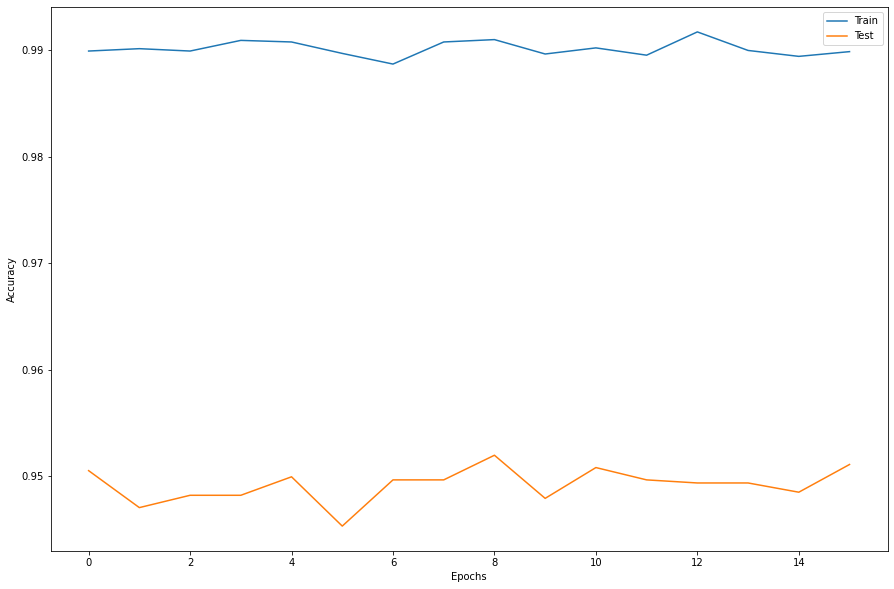

In [78]:
plt.figure(figsize=(15,10))
plt.plot(train_acc_hist, label = 'Train')
plt.plot(valid_acc_hist, label = 'Test')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

Text(0, 0.5, 'Loss')

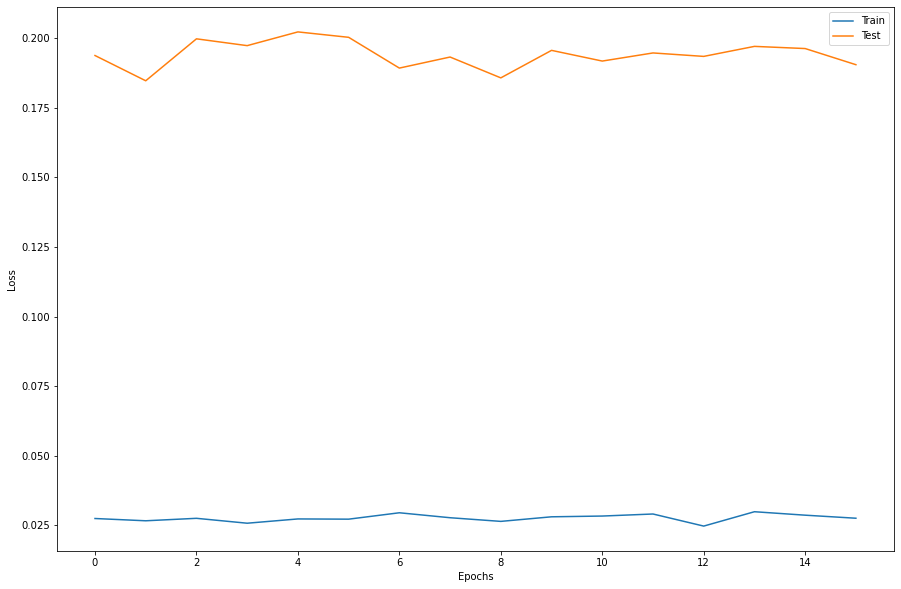

In [79]:
plt.figure(figsize=(15,10))
plt.plot(train_loss_hist, label = 'Train')
plt.plot(valid_loss_hist, label = 'Test')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")

### Inference

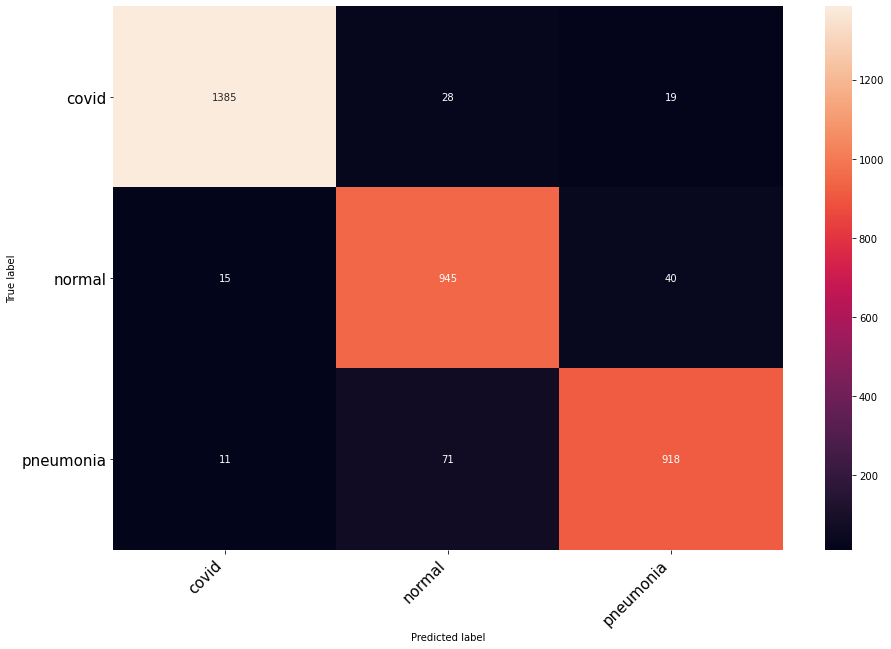

In [23]:
path2weights="/media/brats/DRIVE1/akansh/DeepXrays/Notebooks/Chest-XR-Grand_challenge/efficientNet.pt"
model.load_state_dict(torch.load(path2weights)['model_state_dict'])
model.eval()
confusion_matrix = calc_confusion_matrix(model, validloader,'cuda',3)
plot_confusion_matrix(confusion_matrix, validloader, None)


### Misclassified Images

In [25]:
def view_classify(image,ps,label):
    
    class_name = ['COVID','NORMAL', 'PNEUMONIA']
    classes = np.array(class_name)

    ps = ps.cpu().data.numpy().squeeze()
    
    image = image.permute(1,2,0)
    mean = torch.FloatTensor([0.5027,0.5027,0.5027])
    std = torch.FloatTensor([0.2466, 0.2466, 0.2466])
    
    
    image = image*std + mean
    img = np.clip(image,0,1)
    
    fig, (ax1, ax2) = plt.subplots(figsize=(8,12), ncols=2)
    ax1.imshow(img)
    ax1.set_title('Ground Truth : {}'.format(class_name[label]))
    ax1.axis('off')
    ax2.barh(classes, ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(classes)
    ax2.set_yticklabels(classes)
    ax2.set_title('Predicted Class')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

    return None

In [59]:
missclassified_index = []
for i, (image, labels) in tqdm(enumerate(valid_data)):
    ps = model(image.to(device).unsqueeze(0))
    ps = F.softmax(ps,dim = 1)
    
    if labels != np.argmax(ps.cpu().detach().numpy()):
        missclassified_index.append(i)

0it [00:00, ?it/s]

In [33]:
100-(len(missclassified_index)/3432)*100

94.78438228438229

In [61]:
len(missclassified_index)

174

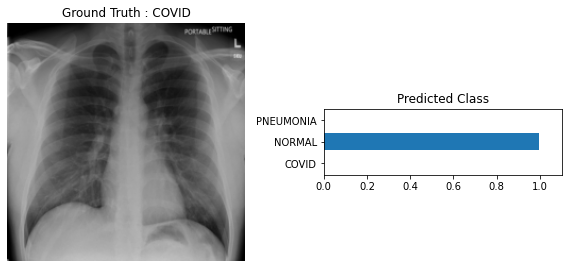

In [60]:
image,label = valid_data[missclassified_index[1]]

ps = model(image.to(device).unsqueeze(0))
ps = F.softmax(ps,dim = 1)

view_classify(image,ps,label)

In [38]:
ps

tensor([[0.5716, 0.4278, 0.0006]], device='cuda:0', grad_fn=<SoftmaxBackward>)